<a href="https://colab.research.google.com/github/wolfinwallst/Machine_Learning_Deep_basis/blob/main/RL_DQN_PyTorch_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

아래는 DQN을 PyTorch로 어떻게 구현할 수 있는지를 익히기 위해서 검색하고 직접 타이핑해본 코드이다. 물론 나의 이해를 위해서, 주석을 일부 수정했다.

[참고](https://yjs-program.tistory.com/173) 를 참고했으며, <펭귄브로의 3분 딥러닝-파이토치맛> 이 소스라고 한다.

In [1]:
pip install gym

In [2]:
import gym # 카트폴 같은 여러 게임 환경 제공 패키지
# pip install gym 으로 설치 가능#
import random # random, math: 에이전트가 무작위로 행동할 확률을 구하기 위함
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
# deque : 먼저 들어온 데이터가 먼저 나가는 FIFO 자료구조의 일종으로 double-ended queue의 약자로, 일반적인 큐와 달리 양쪽 끝에서 삽입,삭제가 모두 가능한 자료구조
import matplotlib.pyplot as plt

In [3]:
# 하이퍼파라미터 정의
EPISODES = 50    # 애피소드(총 플레이할 게임 수) 반복 횟수
EPS_START = 0.9  # 학습 시작시 에이전트가 무작위로 행동할 확률_"epsilon_start"
# ex) 0.5면 50% 절반의 확률로 무작위 행동, 나머지 절반은 학습된 방향으로 행동
# random하게 Epsilon을 두는 이유는 Agent가 가능한 모든 행동을 경험하기 위함
EPS_END = 0.05   # 학습 막바지에 에이전트가 무작위로 행동할 확률
# EPS_START에서 END까지 점진적으로 감소시켜줌
# --> 초반에는 경험을 많이 쌓게 하고, 점차 학습하면서 똑똑해지니깐 학습한대로 진행하게끔
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수 : 에이전트가 현재 reward를 미래 reward보다 얼마나 더 가치있게 여기는지에 대한 값
LR = 0.001
BATCH_SIZE = 64

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256), # 카트 위치-속도, 막대기 각도-속도 4가지 정보 입력
            nn.ReLU(),
            nn.Linear(256, 2) #왼쪽으로 갈 때와 오른쪽으로 갈 때의 가치
        )
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0 # 학습을 반복할 때마다 증가
        self.memory = deque(maxlen=10000) # Replay Buffer다. 가득차면 제일 오래된 데이터부터 삭제

    def memorize(self, state, action, reward, next_state):
        # self.memory = [(s, a, r, s_next)...]
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])
                            ))

    def act(self, state): # action 선택 함수
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1

        # (Epsilon-Greedy)
        # 초기엔 엡실론을 높게=최대한 경험을 많이 하도록 / 엡실론을 낮게 낮춰가며 = 신경망이 선택하는 비율 상승
        if random.random() > eps_threshold: # 학습된 신경망이 옳다고 생각하는 쪽으로
            return self.model(state).data.max(1)[1].view(1, 1)
        else: # 무작위로 행동
            return torch.LongTensor([[random.randrange(2)]])

    def learn(self): # 메모리에 쌓아둔 경험들을 재학습(replay)하며, 학습하는 함수
        if len(self.memory) < BATCH_SIZE: # 메모리에 저장된 에피소드가 batch 크기보다 작으면 학습 보류
            return
        #경험이 충분히 쌓일 때부터 학습 진행
        batch = random.sample(self.memory, BATCH_SIZE) # 메모리에서 무작위로 Batch 크기만큼 가져와서 학습
        states, actions, rewards, next_states = zip(*batch) # 기존의 batch를 요소별 리스트로 분리해줄 수 있게끔

        # 리스트를 Tensor형태로 변환
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        # 현 상태 states에서 행동의 Q값(가치)을 current_q로 모음
        current_q = self.model(states).gather(1, actions)

        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (GAMMA * max_next_q)

        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [5]:
env = gym.make('CartPole-v0')
agent = DQNAgent()
score_history = []

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
# 학습 진행
for e in range(1, EPISODES + 1):
    state = env.reset() # 매번 환경 초기화
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state) # epsilon-greedy policy에 따라 행동 선택
        # action: tensor, item 함수로 에이전트가 수행한 행동의 번호 추출
        next_state, reward, done, _ = env.step(action.item())

        # 게임 끝나면 보상 = -1
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps)
            break

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://se

에피소드:1 점수: 28
에피소드:2 점수: 16
에피소드:3 점수: 13
에피소드:4 점수: 14
에피소드:5 점수: 11
에피소드:6 점수: 18
에피소드:7 점수: 9
에피소드:8 점수: 9
에피소드:9 점수: 15
에피소드:10 점수: 10
에피소드:11 점수: 17
에피소드:12 점수: 13
에피소드:13 점수: 10
에피소드:14 점수: 9
에피소드:15 점수: 11
에피소드:16 점수: 16
에피소드:17 점수: 14
에피소드:18 점수: 12
에피소드:19 점수: 16
에피소드:20 점수: 11
에피소드:21 점수: 10
에피소드:22 점수: 14
에피소드:23 점수: 18
에피소드:24 점수: 12
에피소드:25 점수: 15
에피소드:26 점수: 45
에피소드:27 점수: 81
에피소드:28 점수: 53
에피소드:29 점수: 77
에피소드:30 점수: 37
에피소드:31 점수: 147
에피소드:32 점수: 142
에피소드:33 점수: 161
에피소드:34 점수: 200
에피소드:35 점수: 123
에피소드:36 점수: 142
에피소드:37 점수: 140
에피소드:38 점수: 200
에피소드:39 점수: 199
에피소드:40 점수: 200
에피소드:41 점수: 200
에피소드:42 점수: 175
에피소드:43 점수: 122
에피소드:44 점수: 91
에피소드:45 점수: 200
에피소드:46 점수: 200
에피소드:47 점수: 191
에피소드:48 점수: 132
에피소드:49 점수: 129
에피소드:50 점수: 176


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


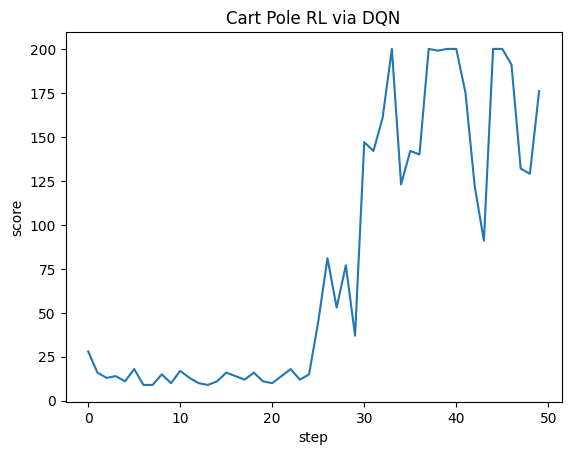

In [7]:
# 점수 기록 시각화
plt.plot(score_history)
plt.title('Cart Pole RL via DQN')
plt.xlabel('step')
plt.ylabel('score')
plt.show()

하이퍼파라미터를 수정하고, 학습 & plot해보자:

여기선 EPS_START, EPS_END, LR 값을 변경해봤다.

In [8]:
EPISODES = 50    # 애피소드(총 플레이할 게임 수) 반복 횟수
EPS_START = 0.8  # 학습 시작시 에이전트가 무작위로 행동할 확률_"epsilon_start"
# ex) 0.5면 50% 절반의 확률로 무작위 행동, 나머지 절반은 학습된 방향으로 행동
# random하게 Epsilon을 두는 이유는 Agent가 가능한 모든 행동을 경험하기 위함
EPS_END = 0.10   # 학습 막바지에 에이전트가 무작위로 행동할 확률
# EPS_START에서 END까지 점진적으로 감소시켜줌
# --> 초반에는 경험을 많이 쌓게 하고, 점차 학습하면서 똑똑해지니깐 학습한대로 진행하게끔
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수 : 에이전트가 현재 reward를 미래 reward보다 얼마나 더 가치있게 여기는지에 대한 값
LR = 0.010

In [9]:
env = gym.make('CartPole-v0')
agent = DQNAgent()
score_history = []

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [10]:
# 학습 진행
for e in range(1, EPISODES + 1):
    state = env.reset() # 매번 환경 초기화
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state) # epsilon-greedy policy에 따라 행동 선택
        # action: tensor, item 함수로 에이전트가 수행한 행동의 번호 추출
        next_state, reward, done, _ = env.step(action.item())

        # 게임 끝나면 보상 = -1
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps)
            break

에피소드:1 점수: 21
에피소드:2 점수: 12
에피소드:3 점수: 21
에피소드:4 점수: 17
에피소드:5 점수: 9
에피소드:6 점수: 11
에피소드:7 점수: 14
에피소드:8 점수: 27
에피소드:9 점수: 10
에피소드:10 점수: 8
에피소드:11 점수: 12
에피소드:12 점수: 112
에피소드:13 점수: 21
에피소드:14 점수: 50
에피소드:15 점수: 59
에피소드:16 점수: 53
에피소드:17 점수: 93
에피소드:18 점수: 76
에피소드:19 점수: 14
에피소드:20 점수: 26
에피소드:21 점수: 43
에피소드:22 점수: 98
에피소드:23 점수: 100
에피소드:24 점수: 168
에피소드:25 점수: 181
에피소드:26 점수: 159
에피소드:27 점수: 200
에피소드:28 점수: 200
에피소드:29 점수: 167
에피소드:30 점수: 165
에피소드:31 점수: 200
에피소드:32 점수: 114
에피소드:33 점수: 115
에피소드:34 점수: 171
에피소드:35 점수: 161
에피소드:36 점수: 151
에피소드:37 점수: 131
에피소드:38 점수: 68
에피소드:39 점수: 125
에피소드:40 점수: 127
에피소드:41 점수: 96
에피소드:42 점수: 55
에피소드:43 점수: 106
에피소드:44 점수: 154
에피소드:45 점수: 196
에피소드:46 점수: 116
에피소드:47 점수: 135
에피소드:48 점수: 48
에피소드:49 점수: 183
에피소드:50 점수: 104


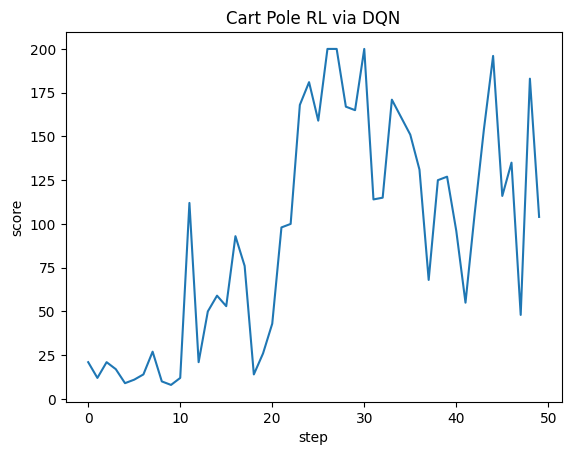

In [11]:
# 점수 기록 시각화
plt.plot(score_history)
plt.title('Cart Pole RL via DQN')
plt.xlabel('step')
plt.ylabel('score')
plt.show()

다시 원본 하이퍼파라미터로 학습을 진행해보자:

In [12]:
# 하이퍼파라미터 정의
EPISODES = 50    # 애피소드(총 플레이할 게임 수) 반복 횟수
EPS_START = 0.9  # 학습 시작시 에이전트가 무작위로 행동할 확률_"epsilon_start"
# ex) 0.5면 50% 절반의 확률로 무작위 행동, 나머지 절반은 학습된 방향으로 행동
# random하게 Epsilon을 두는 이유는 Agent가 가능한 모든 행동을 경험하기 위함
EPS_END = 0.05   # 학습 막바지에 에이전트가 무작위로 행동할 확률
# EPS_START에서 END까지 점진적으로 감소시켜줌
# --> 초반에는 경험을 많이 쌓게 하고, 점차 학습하면서 똑똑해지니깐 학습한대로 진행하게끔
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수 : 에이전트가 현재 reward를 미래 reward보다 얼마나 더 가치있게 여기는지에 대한 값
LR = 0.001
BATCH_SIZE = 64

In [13]:
env = gym.make('CartPole-v0')
agent = DQNAgent()
score_history = []

In [14]:
# 학습 진행
for e in range(1, EPISODES + 1):
    state = env.reset() # 매번 환경 초기화
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state) # epsilon-greedy policy에 따라 행동 선택
        # action: tensor, item 함수로 에이전트가 수행한 행동의 번호 추출
        next_state, reward, done, _ = env.step(action.item())

        # 게임 끝나면 보상 = -1
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps)
            break

에피소드:1 점수: 15
에피소드:2 점수: 20
에피소드:3 점수: 29
에피소드:4 점수: 18
에피소드:5 점수: 12
에피소드:6 점수: 12
에피소드:7 점수: 13
에피소드:8 점수: 11
에피소드:9 점수: 9
에피소드:10 점수: 12
에피소드:11 점수: 10
에피소드:12 점수: 14
에피소드:13 점수: 9
에피소드:14 점수: 9
에피소드:15 점수: 9
에피소드:16 점수: 11
에피소드:17 점수: 9
에피소드:18 점수: 10
에피소드:19 점수: 9
에피소드:20 점수: 19
에피소드:21 점수: 9
에피소드:22 점수: 12
에피소드:23 점수: 11
에피소드:24 점수: 9
에피소드:25 점수: 11
에피소드:26 점수: 39
에피소드:27 점수: 145
에피소드:28 점수: 100
에피소드:29 점수: 63
에피소드:30 점수: 67
에피소드:31 점수: 50
에피소드:32 점수: 55
에피소드:33 점수: 83
에피소드:34 점수: 69
에피소드:35 점수: 89
에피소드:36 점수: 119
에피소드:37 점수: 55
에피소드:38 점수: 120
에피소드:39 점수: 76
에피소드:40 점수: 200
에피소드:41 점수: 139
에피소드:42 점수: 83
에피소드:43 점수: 83
에피소드:44 점수: 98
에피소드:45 점수: 156
에피소드:46 점수: 139
에피소드:47 점수: 171
에피소드:48 점수: 197
에피소드:49 점수: 116
에피소드:50 점수: 182


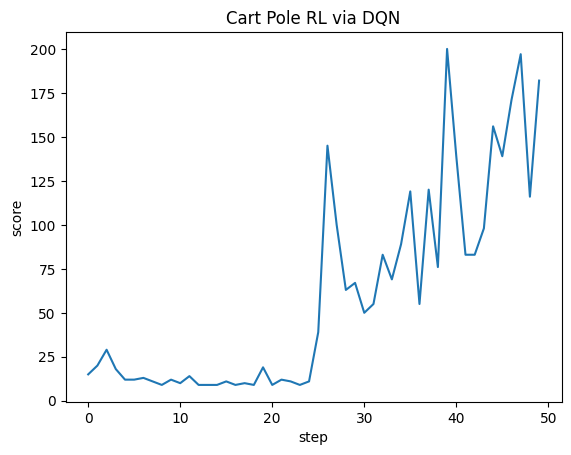

In [15]:
# 점수 기록 시각화
plt.plot(score_history)
plt.title('Cart Pole RL via DQN')
plt.xlabel('step')
plt.ylabel('score')
plt.show()